In [1]:
library(ggplot2)
library(reshape2)

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

In [2]:
predict_func <- function(Phi,w){
    return (Phi%*%w)
    
}
train_obj_func <- function(Phi, w, label, lambda){
    return (0.5*(mean((label - predict_func(Phi,w))^2)) + 0.5*lambda*(w%*%w))
}

In [3]:
train = read.csv('assignment1_datasets/Task2A_train.csv')
test = read.csv('assignment1_datasets/Task2A_test.csv')

train.data = train[,-5]
train.label = train[,5]
test.data = test[,-5]
test.label = test[,5]

In [4]:
train.data=scale(train.data)
train.label=scale(train.label)
test.data=scale(test.data)
test.label=scale(test.label)

train.len = nrow(train)
test.len = nrow(test)

In [5]:
#Stochastic Gradient Descent Algorithm

In [6]:
Phi <- as.matrix(cbind('X0'=1, train.data))
T <- train.label # rename just for conviniance
tau.max <- 20*train.len  # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)
lambda=0.001

W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight

error_sgd <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

In [7]:
while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | train_obj_func(Phi, W[tau,],T,lambda)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | train_obj_func(Phi, W[tau,],T,lambda)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1),j] <- W[tau,j] - eta * (-(T[i]-t_pred) * Phi[i,j] +lambda*W[tau,j])
        }
        
        # record the error:
        error_sgd[tau, 'train'] <- train_obj_func(as.matrix(cbind(1, train.data)), W[tau,],train.label,lambda)
        
        # update the counter:
        tau <- tau + 1 
    }
}

In [8]:
W[tau,]

[1] 0.007026524 0.235620907 0.047410941 0.712308546 0.044175702

In [9]:
error_sgd.m <- melt(error_sgd[1:tau,], id='tau')

In [10]:
colnames(error_sgd) = c('tau','sgd_error')

In [11]:
### BATCH GRADIENT DESCENT ALGORITHM
bgd_train <- function(train.data, train.label, lambda, eta, epsilon, max_epoch){
    
    tau_max <- max_epoch
    train_len <- dim(train.data)[1]
    tau <- 1
    
    Phi <- as.matrix(cbind('X0'=1, train.data))
    W <- matrix(,nrow=tau_max, ncol=ncol(Phi))
    W[1,] <- runif(ncol(Phi))
    
    error_bgd <- data.frame('tau'=1:tau_max)
    #calculating the first error
    error_bgd[tau,'train'] <- train_obj_func(as.matrix(cbind(1, train.data)), W[tau,],train.label, lambda)
    
    #20 weight updates for BGD
    for (tau in 1:(tau_max-1)) {

        # check termination criteria
        if (train_obj_func(Phi, W[tau,],train.label, lambda)<=epsilon) {break}

        # make the weight update
        y_pred <- predict_func(Phi, W[tau,])

        W[tau+1,] <- W[tau,] - eta * (-((t(train.label-y_pred)) %*% Phi)/nrow(Phi) + lambda %*% W[tau,])

        # keep track of the objective funtion
        error_bgd[tau+1,'train'] <- train_obj_func(Phi, W[tau+1,],train.label, lambda)
        
    }
    #changing the values of tau by the size of training data set
    error_bgd['tau'] <- error_bgd['tau']*train.len
    return (error_bgd)
}

In [12]:
error_bgd <- bgd_train(train.data, train.label, lambda = 0.001, eta = 0.01, epsilon = (0.1 * mean(train.label)), max_epoch = 20)

In [13]:
names(error_bgd) <- c('tau', 'bgd_error')

Warning message:
“Removed 1 rows containing missing values (geom_path).”

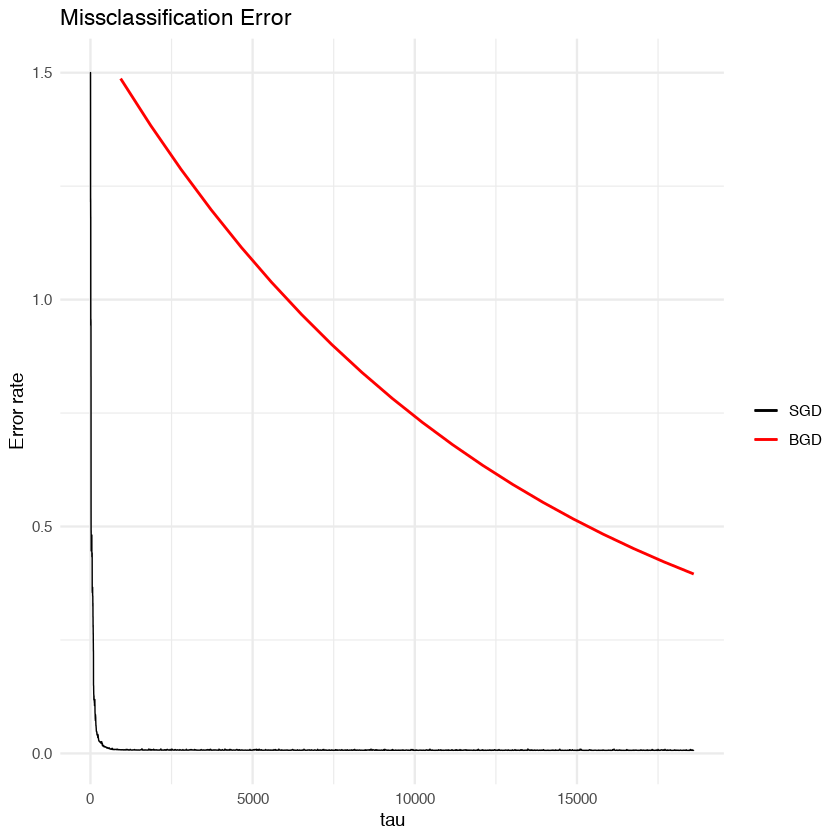

In [14]:
# plot misclassification percentage for train and test data sets
ggplot() + labs(x= "tau", y="Error rate",title = "Missclassification Error") +
geom_line(data=error_sgd, aes(x=tau, y=sgd_error,color='SGD'),size=0.3) + 
geom_line(data=error_bgd, aes(x=tau, y=bgd_error,color='BGD'),size=0.6) +
scale_colour_manual("", breaks = c("SGD", "BGD"),values = c("SGD"="black", "BGD"="red")) +
theme_minimal()

Warning message:
“Removed 183 rows containing missing values (geom_point).”

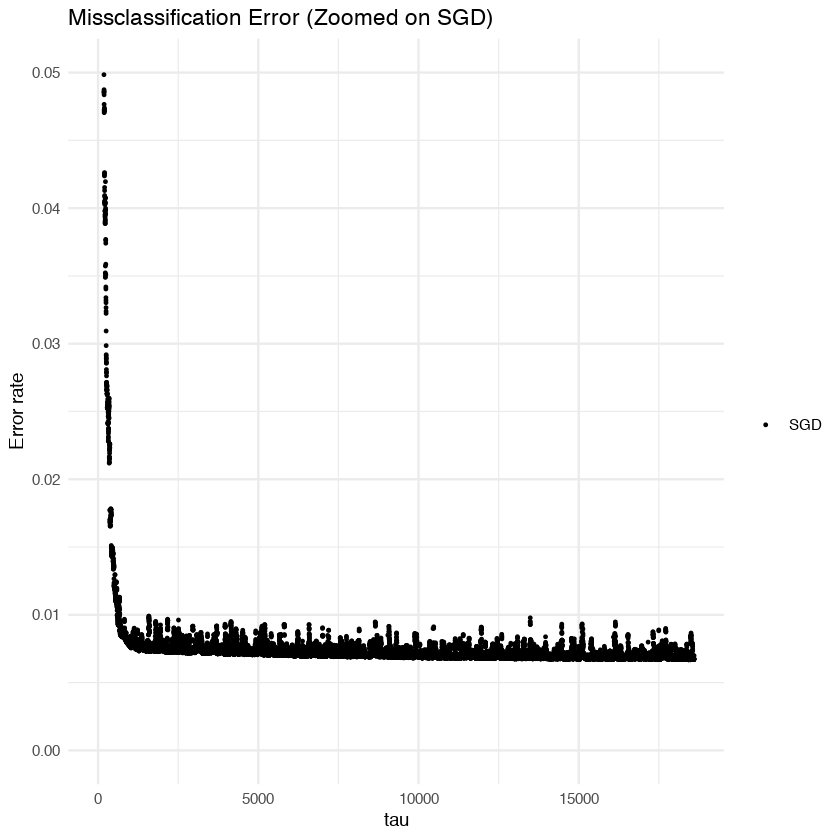

In [15]:
# plot misclassification percentage for train and test data sets
ggplot() + labs(x= "tau", y="Error rate",title = "Missclassification Error (Zoomed on SGD)") +
geom_point(data=error_sgd, aes(x=tau, y=sgd_error,color='SGD'),size=0.3) + 
scale_y_continuous(limits = c(0, 0.05)) +
scale_colour_manual("", breaks = c("SGD"),values = c("SGD"="black")) +
theme_minimal()
options(warn=-1)

#### QIII.d

We can see stochastic gradient algorithm is much faster at converging with less amount of updates compared to the batch gradient descent algorithm. The reason is that in SGD, there is only one update in each iteration (epoch) which also makes its learning path noisier than BGD. If we zoom in the plot for stockhastic gradient(second plot), we can see that it fluctates more than batch gradient descent algorithm. The BGD has a relatively smooth learning curve, because it considers every data point and updates its model paramter accordingly.